In [1]:
using QuantumOptics
using PyPlot

In [2]:
const s_basis = SpinBasis(1//2)
const ma_basis = FockBasis(30)
const mr1_basis = FockBasis(15)
const mr2_basis = FockBasis(15)
const Is = identityoperator(s_basis)
const Ia = identityoperator(ma_basis)
const Ir1 = identityoperator(mr1_basis)
const Ir2 = identityoperator(mr2_basis)
const basis = s_basis ⊗ ma_basis ⊗ mr1_basis ⊗ mr2_basis

[Spin(1/2) ⊗ Fock(cutoff=30) ⊗ Fock(cutoff=15) ⊗ Fock(cutoff=15)]

In [3]:
xop(η, basis) = η * (create(basis) + destroy(basis))

function kop(ηa, ηr1, ηr2)
    xa = xop(ηa, ma_basis)
    xr1 = xop(ηr1, mr1_basis)
    xr2 = xop(ηr2, mr2_basis)
    return xa ⊗ Ir1 ⊗ Ir2 + Ia ⊗ xr1 ⊗ Ir2 + Ia ⊗ Ir1 ⊗ xr2
end

function sys_state(s, na, nr1, nr2)
    return basisstate(s_basis, s + 1) ⊗ fockstate(ma_basis, na) ⊗ fockstate(mr1_basis, nr1) ⊗ fockstate(mr2_basis, nr2)
end

sys_state (generic function with 1 method)

In [4]:
function h0op(E, ωa, ωr1, ωr2)
    return (E * sigmaz(s_basis) ⊗ Ia ⊗ Ir1 ⊗ Ir2 +
        ωa * Is ⊗ number(ma_basis) ⊗ Ir1 ⊗ Ir2 +
        ωr1 * Is ⊗ Ia ⊗ number(mr1_basis) ⊗ Ir2 +
        ωr2 * Is ⊗ Ia ⊗ Ir1 ⊗ number(mr2_basis))
end

h0op (generic function with 1 method)

In [5]:
struct System{OP}
    h0::OP
    xdri::OP
    ydri::OP
end
function System(E, ωa, ωr1, ωr2, ηa, ηr1, ηr2)
    disp = exp(im * kop(ηa, ηr1, ηr2))
    h0 = h0op(E, ωa, ωr1, ωr2)
    return System(h0, sigmax(s_basis) ⊗ disp, sigmay(s_basis) ⊗ disp)
end

System

In [6]:
sys = System(0, 2π * 700e3, 2π * 2.75e6, 2π * 2.85e6, 0.066, 0.024, 0.023)

System{Operator{CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, FockBasis{Int64}, FockBasis{Int64}, FockBasis{Int64}}}, CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, FockBasis{Int64}, FockBasis{Int64}, FockBasis{Int64}}}, SparseArrays.SparseMatrixCSC{ComplexF64, Int64}}}(Operator(dim=15872x15872)
  basis: [Spin(1/2) ⊗ Fock(cutoff=30) ⊗ Fock(cutoff=15) ⊗ Fock(cutoff=15)]sparse([3, 4, 5, 6, 7, 8, 9, 10, 11, 12  …  15863, 15864, 15865, 15866, 15867, 15868, 15869, 15870, 15871, 15872], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12  …  15863, 15864, 15865, 15866, 15867, 15868, 15869, 15870, 15871, 15872], ComplexF64[4.39822971502571e6 + 0.0im, 4.39822971502571e6 + 0.0im, 8.79645943005142e6 + 0.0im, 8.79645943005142e6 + 0.0im, 1.319468914507713e7 + 0.0im, 1.319468914507713e7 + 0.0im, 1.759291886010284e7 + 0.0im, 1.759291886010284e7 + 0.0im, 2.1991148575128548e7 + 0.0im, 2.1991148575128548e7 + 0.0im  …  6.421415383937538e8 + 0.0im, 6.421415383937538e8 + 0.0im, 6.465397681087794e8

In [7]:
function evolve(sys::System, ts, ψ0, Ω, δ; kws...)
    function cb(t, ψ)
        φ = δ * t
        s, c = sincos(φ)
        return sys.h0 + Ω * c * sys.xdri + Ω * s * sys.ydri
    end
    return timeevolution.schroedinger_dynamic(ts, ψ0, cb; kws...)
end

evolve (generic function with 1 method)

In [8]:
ts, ψs = @time evolve(sys, range(0, 5e-6, 1001), sys_state(0, 0, 0, 0), 2π * 50e3, 0);

2607.247220 seconds (15.09 M allocations: 11.385 TiB, 42.12% gc time, 0.10% compilation time)


([0.0, 5.0e-9, 1.0e-8, 1.5e-8, 2.0e-8, 2.5e-8, 3.0e-8, 3.5e-8, 4.0e-8, 4.5e-8  …  4.955e-6, 4.96e-6, 4.965e-6, 4.97e-6, 4.975e-6, 4.98e-6, 4.985e-6, 4.99e-6, 4.995e-6, 5.0e-6], Ket{CompositeBasis{Vector{Int64}, Tuple{SpinBasis{1//2, Int64}, FockBasis{Int64}, FockBasis{Int64}, FockBasis{Int64}}}, Vector{ComplexF64}}[Ket(dim=15872)
  basis: [Spin(1/2) ⊗ Fock(cutoff=30) ⊗ Fock(cutoff=15) ⊗ Fock(cutoff=15)]
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
     ⋮
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im, Ket(dim=15872)
  basis: [Spin(1/2) ⊗ Fock(cutoff=30) ⊗ Fock(cutoff=15) ⊗ Fock(cutoff=15)]
  0.9999987796986446 - 7.611289e-11im
         -2.4558e-13 - 0.00156651248722683im
      -1.75015657e-9 - 1.6106548657e-7im
 0.00010338144072328 - 1.1367798607e-6im
     

In [9]:
rhos = [ptrace(ψ, [2, 3, 4]) for ψ in ψs];

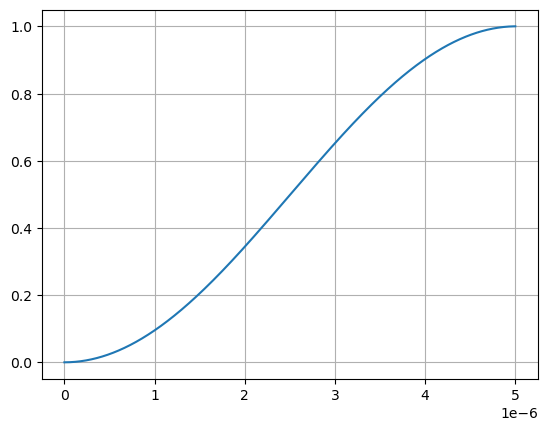

In [11]:
plot(ts, [abs(rho.data[2, 2]) for rho in rhos])
grid()